# Quantium Data Analysis Task 2

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('QVI_data.csv')

In [4]:
data['DATE'] = pd.to_datetime(data['DATE']) # 2018 July 1 to 2019 June 30
# data['MONTH'] = data['DATE'].dt.month
data['MONTH'] = pd.to_datetime(data['DATE']).dt.to_period('M')

In [5]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


According to the client, the numbers of control stores are 77, 86, and 88. The trial testing started in February 2019. 
We would want to match trial stores to control stores that shared a similar sales pattern before February 2019 in terms of the following metrics:
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [7]:
def get_store_monthly_metrics(data, start_month = '2018-07', end_month = '2019-01'):
    store_list = data['STORE_NBR'].drop_duplicates().to_list()
    result = {}
    for store in store_list:
        df_store = data[data['STORE_NBR'] == int(store)]
        monthly_metrics = df_store.groupby('MONTH').agg(
            monthly_total_sales = ('TOT_SALES', 'sum'),
            monthly_total_customer = ('LYLTY_CARD_NBR', 'nunique'),
            monthly_transaction = ('TXN_ID', 'nunique')
        ).reset_index()
        monthly_metrics['avg_txn_per_customer'] = (
            monthly_metrics['monthly_transaction'] / monthly_metrics['monthly_total_customer']
        )
        # filter pre-trial data
        pre_trial = monthly_metrics[
            (monthly_metrics['MONTH'] >= pd.Period(start_month)) & (monthly_metrics['MONTH'] <= pd.Period(end_month))
        ].copy()
        if len(pre_trial) == 7:
            result[store]= pre_trial
    return result

In [8]:
store_pretrial_dict = get_store_monthly_metrics(data)

In [9]:
store_77_df = store_pretrial_dict[77]
store_86_df = store_pretrial_dict[86]
store_88_df = store_pretrial_dict[88]
store_77_df

,MONTH,monthly_total_sales,monthly_total_customer,monthly_transaction,avg_txn_per_customer
0,2018-07,296.8,51,55,1.078431
1,2018-08,255.5,47,48,1.021277
2,2018-09,225.2,42,44,1.047619
3,2018-10,204.5,37,38,1.027027
4,2018-11,245.3,41,44,1.073171
5,2018-12,267.3,46,48,1.043478
6,2019-01,204.4,35,39,1.114286


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [11]:
def calculate_correlation(data, trial_store, metric):
    trial_df = data[trial_store][['MONTH', metric]]
    corr_table = []
    for store_id, df in data.items():
        if store_id == trial_store:
            continue
        control_df = df[['MONTH', metric]]
        merged = pd.merge(trial_df, control_df, on = 'MONTH', suffixes = ('_trial', '_control')).sort_values('MONTH')
        x = merged[f"{metric}_trial"]
        y = merged[f"{metric}_control"]
        if x.nunique() <= 1 or y.nunique() <= 1:
            continue
        try:
            corr, _ = pearsonr(x, y)
            corr_table.append({
                'Store1': trial_store,
                'Store2':store_id, 
                'corr_measure': corr
            })
        except:
            continue
    return pd.DataFrame(corr_table).sort_values(by = 'corr_measure', ascending = False)

In [12]:
corr_sales_77 = calculate_correlation(store_pretrial_dict, 77, 'monthly_total_sales')
corr_sales_77.head()

corr_customer_77 = calculate_correlation(store_pretrial_dict, 77, 'monthly_total_customer')
corr_customer_77.head()

,Store1,Store2,corr_measure
220,77,233,0.990358
111,77,119,0.983267
240,77,254,0.916208
106,77,113,0.901348
78,77,84,0.858571


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.

In [14]:
def calculate_magnitude_distance(trial_store_id, store_dict, metric):
    trial_df = store_dict[trial_store_id][['MONTH', metric]].copy()
    trial_df = trial_df.rename(columns = {metric: 'trial_value'})
    dist_table = []
    for store_id, df in store_dict.items():
        if store_id == trial_store_id:
            continue
        control_df = df[['MONTH', metric]].copy()
        control_df = control_df.rename(columns = {metric: 'control_value'})
        merged_df = pd.merge(trial_df, control_df, on = 'MONTH')
        merged_df['abs_dist'] = abs(merged_df['trial_value'] - merged_df['control_value'])
        merged_df['Store1'] = trial_store_id
        merged_df['Store2'] = store_id
        dist_table.append(merged_df[['Store1', 'Store2', 'MONTH', 'abs_dist']])
    dist_table_df = pd.concat(dist_table)
    min_max = dist_table_df.groupby(['Store1', 'MONTH'])['abs_dist'].agg(['min', 'max']).reset_index()
    dist_table_df = dist_table_df.merge(min_max, on = ['Store1', 'MONTH'])
    dist_table_df['magnitude'] = 1 - (dist_table_df['abs_dist'] - dist_table_df['min']) / (dist_table_df['max'] - dist_table_df['min'] + 1e-9)
    result_df = dist_table_df.groupby(['Store1', 'Store2'])['magnitude'].mean().reset_index()
    result_df = result_df.rename(columns = {'magnitude': 'mag_measure'})
    return result_df.sort_values(by = 'mag_measure', ascending = False)

In [15]:
magnitude_sales_77 = calculate_magnitude_distance(77, store_pretrial_dict, 'monthly_total_sales')
magnitude_sales_77.head()

,Store1,Store2,mag_measure
220,77,233,0.987091
241,77,255,0.978526
49,77,53,0.977210
179,77,188,0.976961
122,77,131,0.976774


In [16]:
magnitude_customer_77 = calculate_magnitude_distance(77, store_pretrial_dict, 'monthly_total_customer')
magnitude_customer_77.head()

,Store1,Store2,mag_measure
220,77,233,0.992773
38,77,41,0.974639
103,77,111,0.966064
107,77,115,0.965916
15,77,17,0.962495


We’ll need to combine the all the scores calculated using our function to create a composite score to rank on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [18]:
#### Create a combined score composed of correlation and magnitude

def combine_score(corr_sales_df, mag_sales_df, corr_cust_df, mag_cust_df, corr_weight = 0.5):
    score_nSales = pd.merge(corr_sales_df, mag_sales_df, on = ['Store1', 'Store2'])
    score_nSales['scoreNSales'] = (
        score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)
    )
    score_nCustomers = pd.merge(corr_cust_df, mag_cust_df, on = ['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = (
        score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)
    )
    score_control = pd.merge(score_nSales[['Store1', 'Store2', 'scoreNSales']],
                            score_nCustomers[['Store1', 'Store2', 'scoreNCust']], 
                            on = ['Store1', 'Store2'])
    score_control['finalControlScore'] = (
        score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5
    )
    return score_control.sort_values(by = 'finalControlScore', ascending = False).head(1)['Store2'].iloc[0]

In [19]:
final_score_77 = combine_score(corr_sales_77, magnitude_sales_77, corr_customer_77, magnitude_customer_77, 0.5)
final_score_77

233

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.

### Trial and contorl store pair 1 (77 & 233)

In [22]:
def get_store_monthly_metrics_fullperiod(data):
    store_list = data['STORE_NBR'].drop_duplicates().to_list()
    result = {}
    for store in store_list:
        df_store = data[data['STORE_NBR'] == int(store)]
        monthly_metrics = df_store.groupby('MONTH').agg(
            monthly_total_sales = ('TOT_SALES', 'sum'),
            monthly_total_customer = ('LYLTY_CARD_NBR', 'nunique'),
            monthly_transaction = ('TXN_ID', 'nunique')
        ).reset_index()
        monthly_metrics['avg_txn_per_customer'] = (
            monthly_metrics['monthly_transaction'] / monthly_metrics['monthly_total_customer']
        )
        result[store]= monthly_metrics
    return result

In [23]:
full_df = get_store_monthly_metrics_fullperiod(data)
# Trial stores
store_77_df_all = full_df[77]
store_86_df_all = full_df[86]
store_88_df_all = full_df[88]
# control stores 
store_233_df_all = full_df[233]
store_155_df_all = full_df[155]
store_237_df_all = full_df[237]

In [24]:
def mean_of_other_stores(trial_store_id, control_store_id, data):
    dfs_to_concat = []
    
    for store_id, df in data.items():
        if store_id in [trial_store_id, control_store_id]:
            continue
        if pd.api.types.is_period_dtype(df['MONTH']):
            df = df.copy()
            df['MONTH'] = df['MONTH'].dt.to_timestamp()
        dfs_to_concat.append(df)

    combined_df = pd.concat(dfs_to_concat)

    avg_df = combined_df.groupby('MONTH').agg({
        'monthly_total_sales':'mean',
        'monthly_total_customer':'mean',
        'monthly_transaction':'mean'
    }).reset_index()
    return avg_df        
other_df = mean_of_other_stores(77, 233, full_df)

In [25]:
store_77_df_all['MONTH'] = store_77_df_all['MONTH'].dt.to_timestamp()
store_233_df_all['MONTH'] = store_233_df_all['MONTH'].dt.to_timestamp()
#other_df['MONTH'] = other_df['MONTH'].dt.to_timestamp()

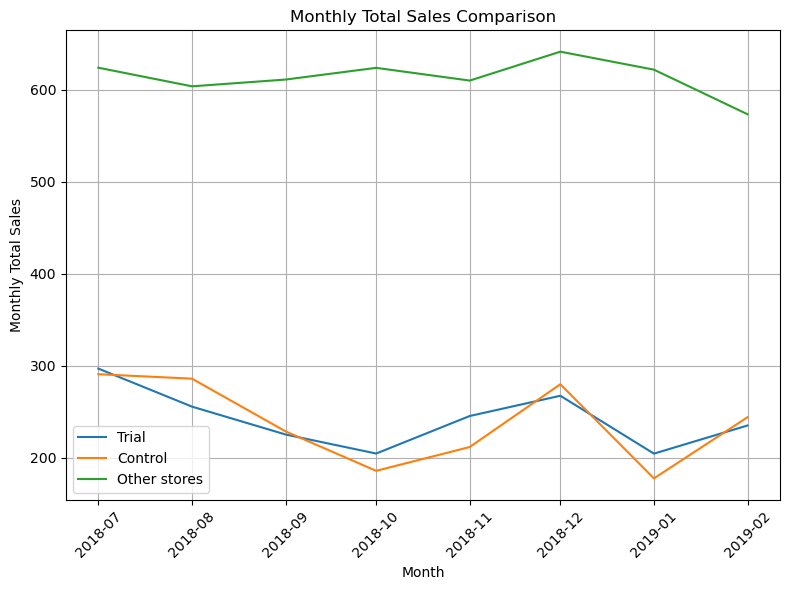

In [26]:
# We'll look at total sales first.
plt.figure(figsize=(8, 6))

plt.plot(store_77_df_all['MONTH'][:-4], store_77_df_all['monthly_total_sales'][:-4], label='Trial')
plt.plot(store_233_df_all['MONTH'][:-4], store_233_df_all['monthly_total_sales'][:-4], label='Control')
plt.plot(other_df['MONTH'][:-4], other_df['monthly_total_sales'][:-4], label='Other stores')

plt.title('Monthly Total Sales Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Next, number of customers

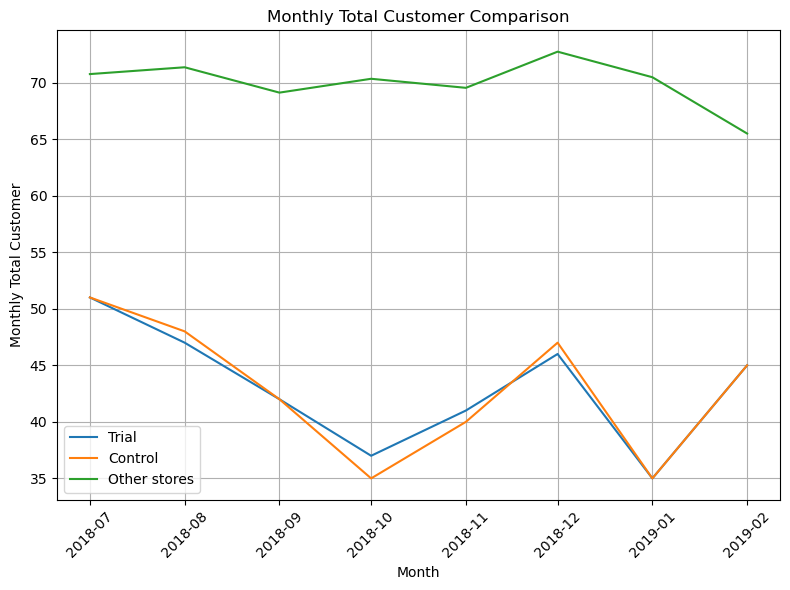

In [28]:
plt.figure(figsize=(8, 6))

plt.plot(store_77_df_all['MONTH'][:-4], store_77_df_all['monthly_total_customer'][:-4], label='Trial')
plt.plot(store_233_df_all['MONTH'][:-4], store_233_df_all['monthly_total_customer'][:-4], label='Control')
plt.plot(other_df['MONTH'][:-4], other_df['monthly_total_customer'][:-4], label='Other stores')

plt.title('Monthly Total Customer Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Customer')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Assessment of trial

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

In [30]:
#### Scale pre‐trial control sales to match pre‐trial trial store sales
def get_scaling_factor(trial_df, control_df, metric):
    trial_pre = trial_df[:-5]
    control_pre = control_df[:-5]
    trial_sum = trial_pre[metric].sum()
    control_sum = control_pre[metric].sum()
    return trial_sum / control_sum

In [31]:
scaling_factor_for_sales = get_scaling_factor(store_77_df_all, store_233_df_all, 'monthly_total_sales')
store_233_df_all['scaled_sales'] = store_233_df_all['monthly_total_sales'] * scaling_factor_for_sales

Now that we have comparable sales figures for the control store, we can calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [33]:
#### Calculate the percentage difference between scaled control sales and trial sales
comparison_df = pd.merge(
    store_77_df_all[['MONTH', 'monthly_total_sales']],
    store_233_df_all[['MONTH', 'scaled_sales']],
    on='MONTH'
)

comparison_df['percentage_diff'] = (
    abs(comparison_df['scaled_sales'] - comparison_df['monthly_total_sales']) / comparison_df['scaled_sales']
)

Let’s see if the difference is significant!

H0 (Null hypothesis): The fluctuation of monthly sales between the trial period and the pre-trial period has no difference. 

In [35]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

from scipy.stats import t
std = comparison_df[comparison_df['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df['MONTH'] >= '2019-02') & (comparison_df['MONTH'] < '2019-06')
comparison_df.loc[trial_period_mask, 't_value'] = (
    comparison_df.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df.loc[trial_period_mask, ['MONTH', 't_value']]

0.04994076264142537


,MONTH,t_value
7,2019-02-01,1.183534
8,2019-03-01,7.339116
9,2019-04-01,12.476373
10,2019-05-01,3.023650


In [36]:
# 95th percentile value of t-value
t_critical

1.894578605061305

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.


Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

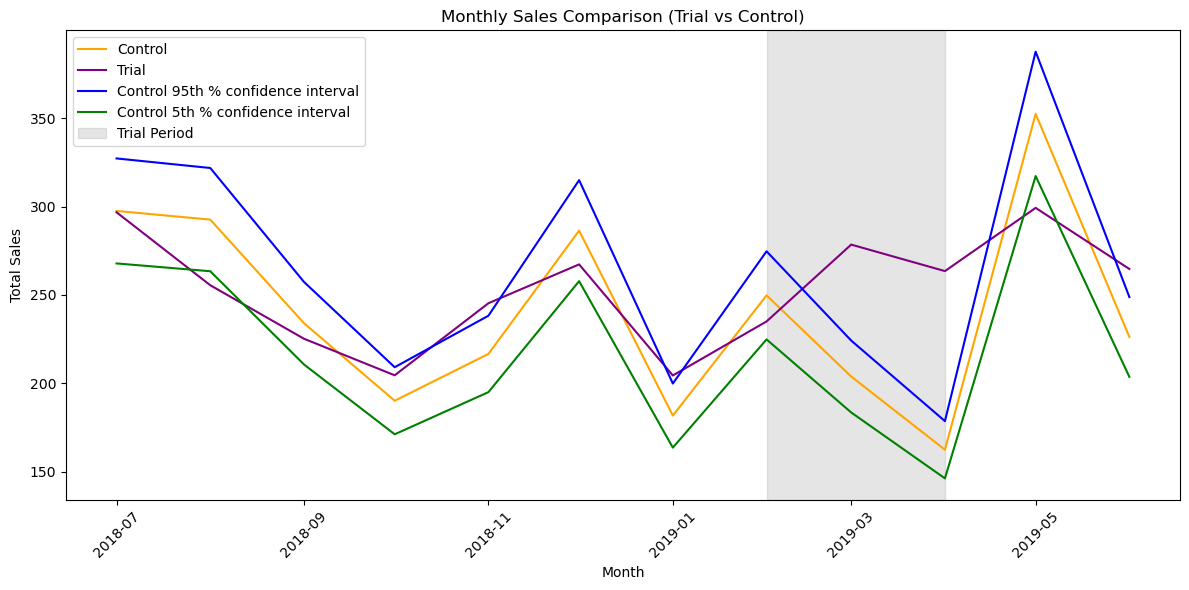

In [39]:
comparison_df_plot = comparison_df.copy()
comparison_df_plot['upper_95'] = comparison_df_plot['scaled_sales'] * (1 + 2 * std)
comparison_df_plot['lower_5'] = comparison_df_plot['scaled_sales'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['scaled_sales'], label = 'Control', color = 'orange')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['monthly_total_sales'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Comparison (Trial vs Control)')
plt.legend()
#plt.ylim(0, 325)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

Assessing this for number of customers as well. 

In [42]:
scaling_factor_for_customer = get_scaling_factor(store_77_df_all, store_233_df_all, 'monthly_total_customer')
store_233_df_all['scaled_customer'] = store_233_df_all['monthly_total_customer'] * scaling_factor_for_customer

In [43]:
comparison_df_customer = pd.merge(
    store_77_df_all[['MONTH', 'monthly_total_customer']],
    store_233_df_all[['MONTH', 'scaled_customer']],
    on='MONTH'
)

comparison_df_customer['percentage_diff'] = (
    abs(comparison_df_customer['monthly_total_customer'] - comparison_df_customer['scaled_customer']) / comparison_df_customer['scaled_customer']
)

In [44]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

std = comparison_df_customer[comparison_df_customer['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df_customer['MONTH'] >= '2019-02') & (comparison_df_customer['MONTH'] < '2019-06')
comparison_df_customer.loc[trial_period_mask, 't_value'] = (
    comparison_df_customer.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df_customer.loc[trial_period_mask, ['MONTH', 't_value']]

0.01824074855824395


,MONTH,t_value
7,2019-02-01,0.183352
8,2019-03-01,13.476388
9,2019-04-01,30.778725
10,2019-05-01,2.100509


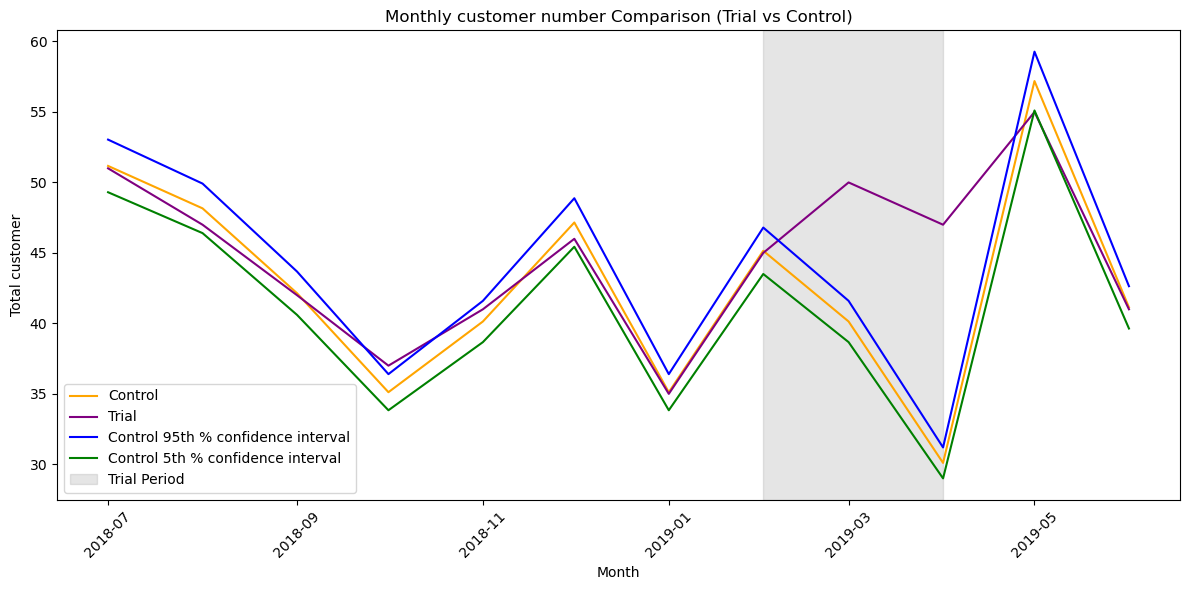

In [45]:
comparison_df_plot = comparison_df_customer.copy()
comparison_df_plot['upper_95'] = comparison_df_plot['scaled_customer'] * (1 + 2 * std)
comparison_df_plot['lower_5'] = comparison_df_plot['scaled_customer'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['scaled_customer'], label = 'Control', color = 'orange')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['monthly_total_customer'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_plot['MONTH'], comparison_df_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total customer')
plt.title('Monthly customer number Comparison (Trial vs Control)')
plt.legend()
#plt.ylim(0, 325)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.
### Trial - Control pair 2 (86 vs 155)

In [47]:
# control and trial pair for store 86
corr_sales_86 = calculate_correlation(store_pretrial_dict, 86, 'monthly_total_sales')
corr_customer_86 = calculate_correlation(store_pretrial_dict, 86, 'monthly_total_customer')
magnitude_sales_86 = calculate_magnitude_distance(86, store_pretrial_dict, 'monthly_total_sales')
magnitude_customer_86 = calculate_magnitude_distance(86, store_pretrial_dict, 'monthly_total_customer')
final_score_86 = combine_score(corr_sales_86, magnitude_sales_86, corr_customer_86, magnitude_customer_86, 0.5)
final_score_86

155

Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are indeed similar in the period before the trial.

In [49]:
other_df_86 = mean_of_other_stores(86, 155, full_df)

In [50]:
store_86_df_all['MONTH'] = store_86_df_all['MONTH'].dt.to_timestamp()
store_155_df_all['MONTH'] = store_155_df_all['MONTH'].dt.to_timestamp()

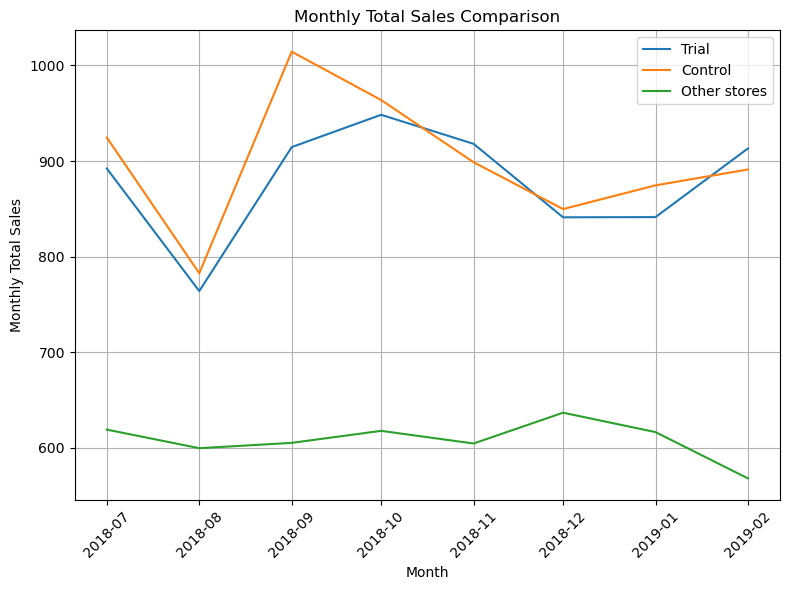

In [51]:
# We'll look at total sales first.
plt.figure(figsize=(8, 6))

plt.plot(store_86_df_all['MONTH'][:-4], store_86_df_all['monthly_total_sales'][:-4], label='Trial')
plt.plot(store_155_df_all['MONTH'][:-4], store_155_df_all['monthly_total_sales'][:-4], label='Control')
plt.plot(other_df_86['MONTH'][:-4], other_df_86['monthly_total_sales'][:-4], label='Other stores')

plt.title('Monthly Total Sales Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

sales are trending in a similar way

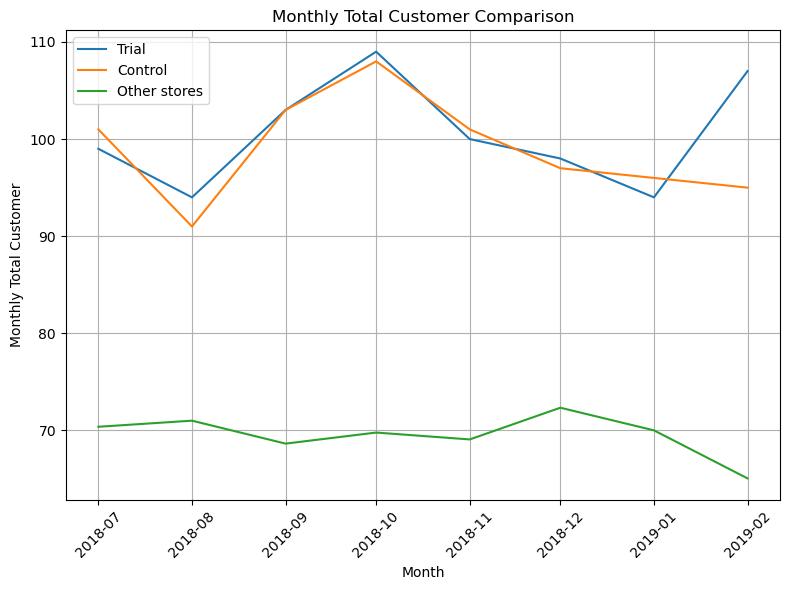

In [53]:
plt.figure(figsize=(8, 6))

plt.plot(store_86_df_all['MONTH'][:-4], store_86_df_all['monthly_total_customer'][:-4], label='Trial')
plt.plot(store_155_df_all['MONTH'][:-4], store_155_df_all['monthly_total_customer'][:-4], label='Control')
plt.plot(other_df_86['MONTH'][:-4], other_df_86['monthly_total_customer'][:-4], label='Other stores')

plt.title('Monthly Total Customer Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Customer')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

the trend in number of customers is also similar. 

Let's now assess the impact of the trial on sales. 

In [55]:
scaling_factor_for_sales = get_scaling_factor(store_86_df_all, store_155_df_all, 'monthly_total_sales')
store_155_df_all['scaled_sales'] = store_155_df_all['monthly_total_sales'] * scaling_factor_for_sales

#### Calculate the percentage difference between scaled control sales and trial sales
comparison_df_86 = pd.merge(
    store_86_df_all[['MONTH', 'monthly_total_sales']],
    store_155_df_all[['MONTH', 'scaled_sales']],
    on='MONTH'
)

comparison_df_86['percentage_diff'] = (
    abs(comparison_df_86['scaled_sales'] - comparison_df_86['monthly_total_sales']) / comparison_df_86['scaled_sales']
)

In [56]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

std = comparison_df_86[comparison_df_86['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df_86['MONTH'] >= '2019-02') & (comparison_df_86['MONTH'] < '2019-06')
comparison_df_86.loc[trial_period_mask, 't_value'] = (
    comparison_df_86.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df_86.loc[trial_period_mask, ['MONTH', 't_value']]

0.025833952854772368


,MONTH,t_value
7,2019-02-01,2.179542
8,2019-03-01,12.226922
9,2019-04-01,1.364580
10,2019-05-01,0.256176


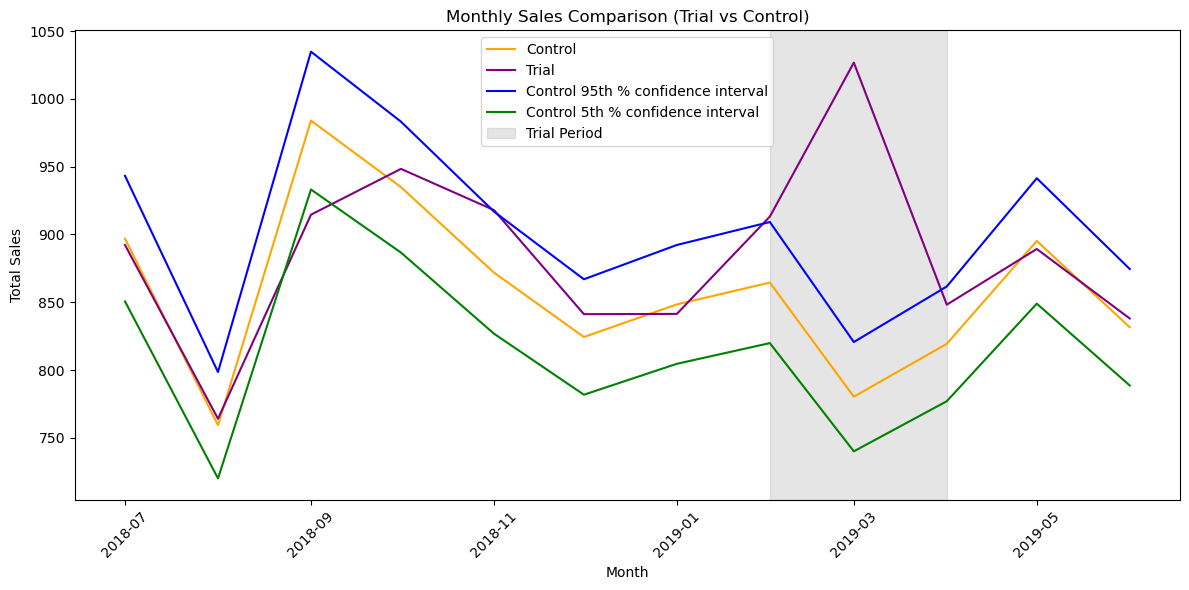

In [57]:
comparison_df_86_plot = comparison_df_86.copy()
comparison_df_86_plot['upper_95'] = comparison_df_86_plot['scaled_sales'] * (1 + 2 * std)
comparison_df_86_plot['lower_5'] = comparison_df_86_plot['scaled_sales'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['scaled_sales'], label = 'Control', color = 'orange')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['monthly_total_sales'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Comparison (Trial vs Control)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

Let’s have a look at assessing this for number of customers as well.

In [59]:
# Applying the scaling factor for customer 
scaling_factor_for_customer = get_scaling_factor(store_86_df_all, store_155_df_all, 'monthly_total_customer')
store_155_df_all['scaled_customer'] = store_155_df_all['monthly_total_customer'] * scaling_factor_for_customer

#### Calculate the percentage difference between scaled control sales and trial sales
comparison_df_86_customer = pd.merge(
    store_86_df_all[['MONTH', 'monthly_total_customer']],
    store_155_df_all[['MONTH', 'scaled_customer']],
    on='MONTH'
)

comparison_df_86_customer['percentage_diff'] = (
    abs(comparison_df_86_customer['monthly_total_customer'] - comparison_df_86_customer['scaled_customer']) / comparison_df_86_customer['scaled_customer']
)

In [60]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

std = comparison_df_86_customer[comparison_df_86_customer['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df_86_customer['MONTH'] >= '2019-02') & (comparison_df_86_customer['MONTH'] < '2019-06')
comparison_df_86_customer.loc[trial_period_mask, 't_value'] = (
    comparison_df_86_customer.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df_86_customer.loc[trial_period_mask, ['MONTH', 't_value']]

0.010687444701395238


,MONTH,t_value
7,2019-02-01,11.819082
8,2019-03-01,20.903430
9,2019-04-01,5.670772
10,2019-05-01,1.765429


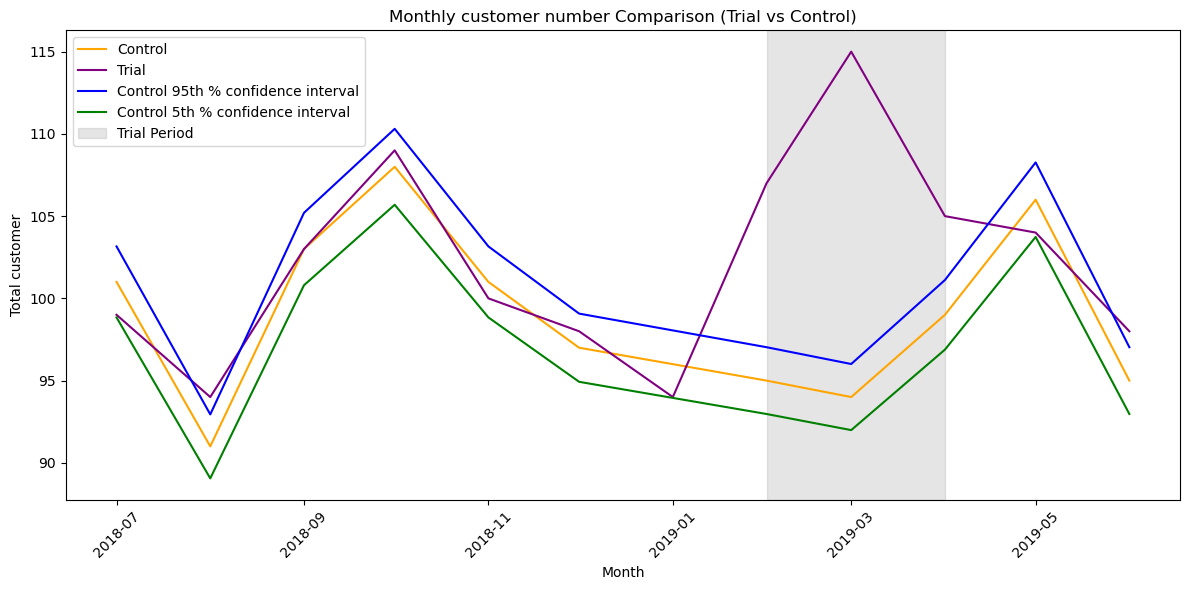

In [61]:
comparison_df_86_plot = comparison_df_86_customer.copy()
comparison_df_86_plot['upper_95'] = comparison_df_86_plot['scaled_customer'] * (1 + 2 * std)
comparison_df_86_plot['lower_5'] = comparison_df_86_plot['scaled_customer'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['scaled_customer'], label = 'Control', color = 'orange')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['monthly_total_customer'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_86_plot['MONTH'], comparison_df_86_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total customer')
plt.title('Monthly customer number Comparison (Trial vs Control)')
plt.legend()
#plt.ylim(0, 325)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It looks like the number of customers is significantly higher in all three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86. So, based on both results of the trial store 86, we can conclude a significant difference between trial store 86 and control store 155. 

## Trial - Control store pair (88 - 237)

In [64]:
# control and trial pair for store 88
corr_sales_88 = calculate_correlation(store_pretrial_dict, 88, 'monthly_total_sales')
corr_customer_88 = calculate_correlation(store_pretrial_dict, 88, 'monthly_total_customer')
magnitude_sales_88 = calculate_magnitude_distance(88, store_pretrial_dict, 'monthly_total_sales')
magnitude_customer_88 = calculate_magnitude_distance(88, store_pretrial_dict, 'monthly_total_customer')
final_score_88 = combine_score(corr_sales_88, magnitude_sales_88, corr_customer_88, magnitude_customer_88, 0.5)
final_score_88

237

In [65]:
other_df_88 = mean_of_other_stores(88, 237, full_df)

In [66]:
store_88_df_all['MONTH'] = store_88_df_all['MONTH'].dt.to_timestamp()
store_237_df_all['MONTH'] = store_237_df_all['MONTH'].dt.to_timestamp()

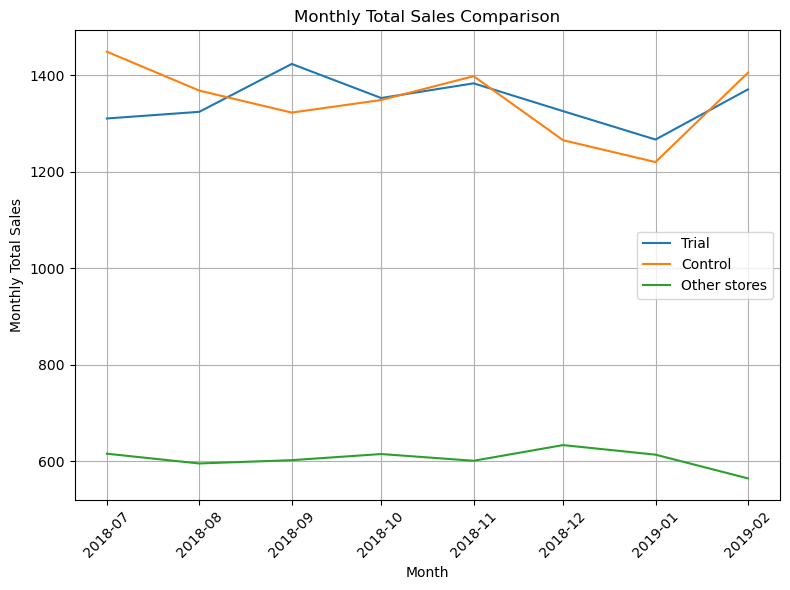

In [67]:
# We'll look at total sales first.
plt.figure(figsize=(8, 6))

plt.plot(store_88_df_all['MONTH'][:-4], store_88_df_all['monthly_total_sales'][:-4], label='Trial')
plt.plot(store_237_df_all['MONTH'][:-4], store_237_df_all['monthly_total_sales'][:-4], label='Control')
plt.plot(other_df_88['MONTH'][:-4], other_df_88['monthly_total_sales'][:-4], label='Other stores')

plt.title('Monthly Total Sales Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The trial and control stores have similar total sales.
Next, number of customers.

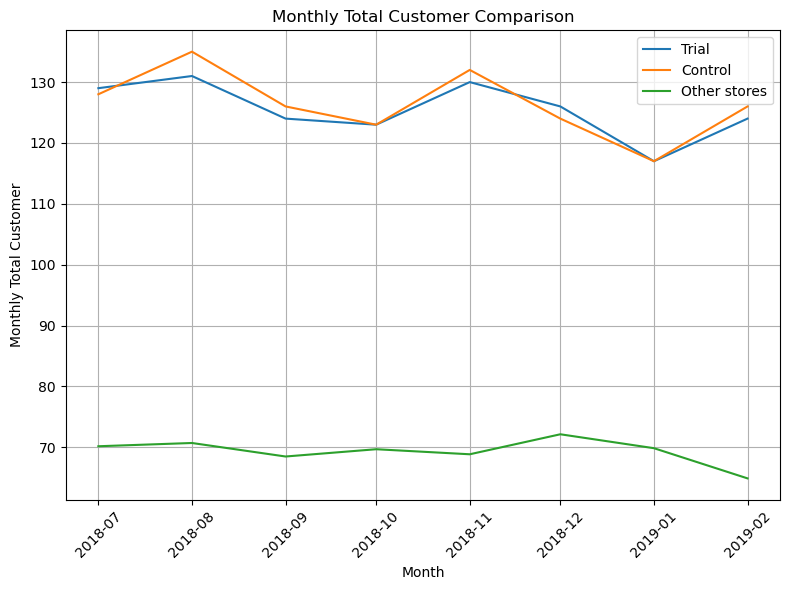

In [69]:
plt.figure(figsize=(8, 6))

plt.plot(store_88_df_all['MONTH'][:-4], store_88_df_all['monthly_total_customer'][:-4], label='Trial')
plt.plot(store_237_df_all['MONTH'][:-4], store_237_df_all['monthly_total_customer'][:-4], label='Control')
plt.plot(other_df_88['MONTH'][:-4], other_df_88['monthly_total_customer'][:-4], label='Other stores')

plt.title('Monthly Total Customer Comparison')
plt.xlabel('Month')
plt.ylabel('Monthly Total Customer')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Total number of customers of the control and trial stores are also similar.
Let’s now assess the impact of the trial on sales.

In [71]:
scaling_factor_for_sales = get_scaling_factor(store_88_df_all, store_237_df_all, 'monthly_total_sales')
store_237_df_all['scaled_sales'] = store_237_df_all['monthly_total_sales'] * scaling_factor_for_sales

#### Calculate the percentage difference between scaled control sales and trial sales
comparison_df_88 = pd.merge(
    store_88_df_all[['MONTH', 'monthly_total_sales']],
    store_237_df_all[['MONTH', 'scaled_sales']],
    on='MONTH'
)

comparison_df_88['percentage_diff'] = (
    abs(comparison_df_88['scaled_sales'] - comparison_df_88['monthly_total_sales']) / comparison_df_88['scaled_sales']
)

In [72]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

std = comparison_df_88[comparison_df_88['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df_88['MONTH'] >= '2019-02') & (comparison_df_88['MONTH'] < '2019-06')
comparison_df_88.loc[trial_period_mask, 't_value'] = (
    comparison_df_88.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df_88.loc[trial_period_mask, ['MONTH', 't_value']]

0.0334678673030788


,MONTH,t_value
7,2019-02-01,0.781270
8,2019-03-01,6.595668
9,2019-04-01,5.768527
10,2019-05-01,2.663672


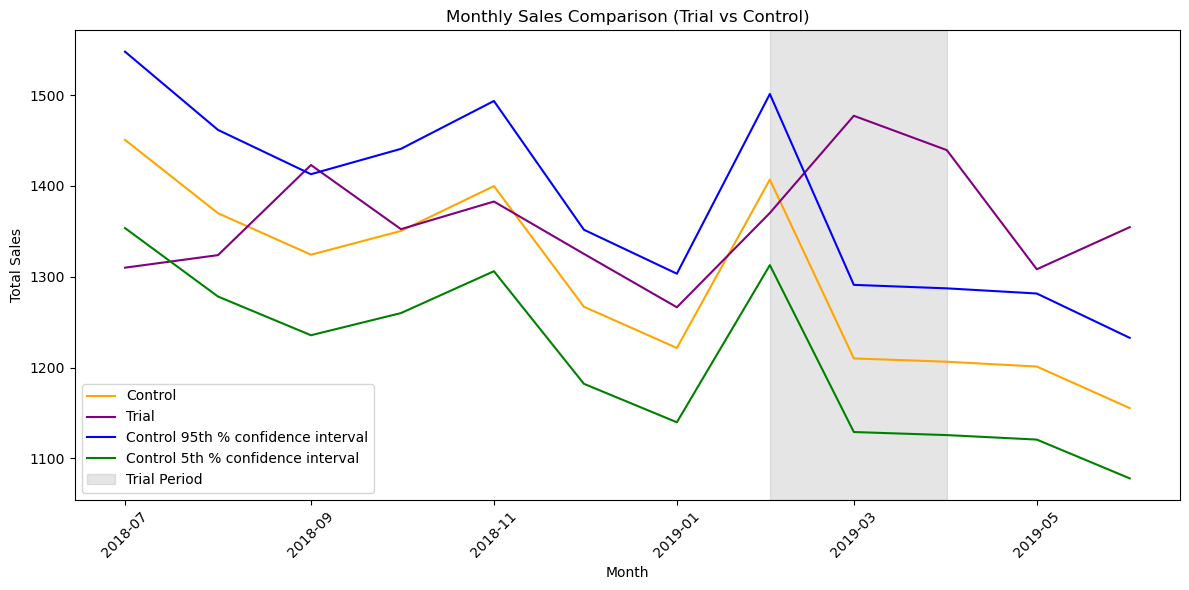

In [73]:
comparison_df_88_plot = comparison_df_88.copy()
comparison_df_88_plot['upper_95'] = comparison_df_88_plot['scaled_sales'] * (1 + 2 * std)
comparison_df_88_plot['lower_5'] = comparison_df_88_plot['scaled_sales'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['scaled_sales'], label = 'Control', color = 'orange')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['monthly_total_sales'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Comparison (Trial vs Control)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months.

Let’s have a look at assessing this for number of customers as well

In [75]:
# Applying the scaling factor for customer 
scaling_factor_for_customer = get_scaling_factor(store_88_df_all, store_237_df_all, 'monthly_total_customer')
store_237_df_all['scaled_customer'] = store_237_df_all['monthly_total_customer'] * scaling_factor_for_customer

#### Calculate the percentage difference between scaled control sales and trial sales
comparison_df_88_customer = pd.merge(
    store_88_df_all[['MONTH', 'monthly_total_customer']],
    store_237_df_all[['MONTH', 'scaled_customer']],
    on='MONTH'
)

comparison_df_88_customer['percentage_diff'] = (
    abs(comparison_df_88_customer['monthly_total_customer'] - comparison_df_88_customer['scaled_customer']) / comparison_df_88_customer['scaled_customer']
)

In [76]:
#### As our null hypothesis is that the trial period is the same as the pre‐trial period, 
## let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

std = comparison_df_88_customer[comparison_df_88_customer['MONTH'] < '2019-02']['percentage_diff'].std()
print(std)
trial_period_mask = (comparison_df_88_customer['MONTH'] >= '2019-02') & (comparison_df_88_customer['MONTH'] < '2019-06')
comparison_df_88_customer.loc[trial_period_mask, 't_value'] = (
    comparison_df_88_customer.loc[trial_period_mask, 'percentage_diff'] / std
)

t_critical = t.ppf(0.95, df = 7)
comparison_df_88_customer.loc[trial_period_mask, ['MONTH', 't_value']]

0.00741024435207507


,MONTH,t_value
7,2019-02-01,1.387456
8,2019-03-01,17.873693
9,2019-04-01,9.814423
10,2019-05-01,0.285303


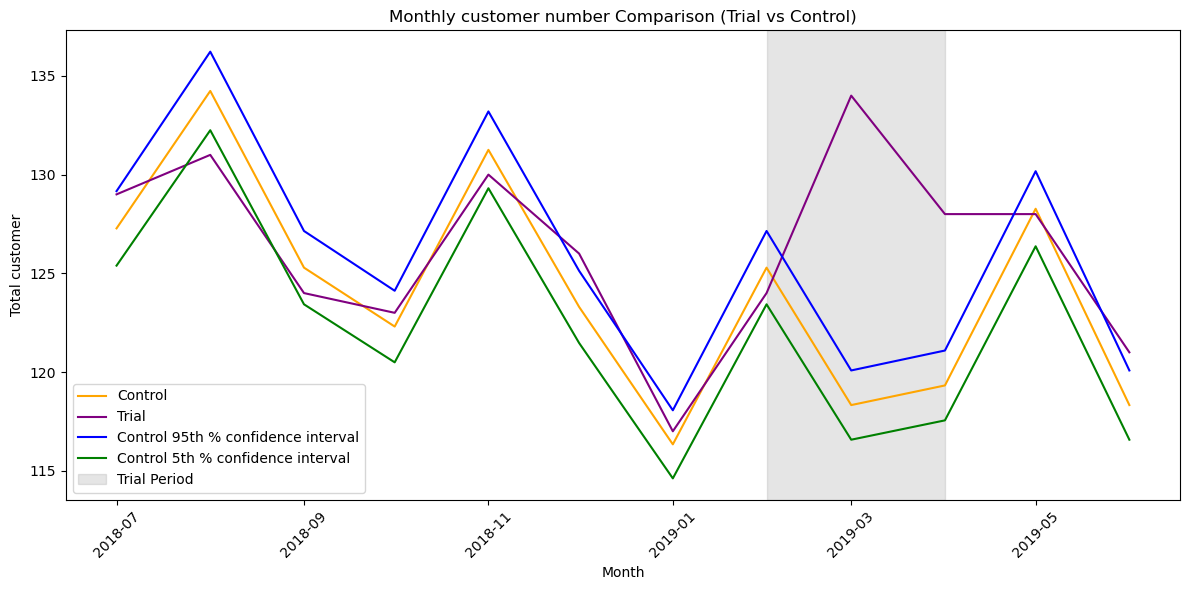

In [77]:
comparison_df_88_plot = comparison_df_88_customer.copy()
comparison_df_88_plot['upper_95'] = comparison_df_88_plot['scaled_customer'] * (1 + 2 * std)
comparison_df_88_plot['lower_5'] = comparison_df_88_plot['scaled_customer'] *(1 - 2 * std)
# plot 
plt.figure(figsize = (12,6))
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['scaled_customer'], label = 'Control', color = 'orange')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['monthly_total_customer'], label = 'Trial', color = 'purple')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['upper_95'], label = 'Control 95th % confidence interval', color = 'blue')
plt.plot(comparison_df_88_plot['MONTH'], comparison_df_88_plot['lower_5'], label = 'Control 5th % confidence interval', color = 'green')
plt.axvspan(pd.to_datetime('2019-02'), pd.to_datetime('2019-04'), color = 'gray', alpha = 0.2, label = 'Trial Period')
plt.xlabel('Month')
plt.ylabel('Total customer')
plt.title('Monthly customer number Comparison (Trial vs Control)')
plt.legend()
#plt.ylim(0, 325)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Total number of customers in the trial period for the trial store is significantly higher than the control store for two out of three months, which indicates a positive trial effect.


### Conclusion

We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for three trail stores (77, 86, 88) during the trial period show a significant difference in at least two of the three trial months. 
Overall the trial shows a significant increase in sales.